# Spotify Content-Based Recommendation Engine
## Three Different Approaches Compared

1. **TF-IDF + Cosine Similarity** (Best quality)
2. **K-Nearest Neighbors** (Fast & scalable)
3. **Autoencoder (Deep Learning)** (Learns latent features)

Dataset: ~6,300 Spotify tracks with metadata

---

## 1. Import Libraries & Load Data

In [4]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8')

# Preprocessing & Modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import hstack

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv(r"C:\Users\Lenovo\OneDrive\سطح المكتب\spotify-recommender\data\spotify_tracks.csv")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6300, 8)


,id,name,genre,artists,album,popularity,duration_ms,explicit
0,7kr3xZk4yb3YSZ4VFtg2Qt,Acoustic,acoustic,Billy Raffoul,1975,58,172199,False
1,1kJygfS4eoVziBBI93MSYp,Acoustic,acoustic,Billy Raffoul,A Few More Hours at YYZ,57,172202,False
2,6lynns69p4zTCRxmmiSY1x,Here Comes the Sun - Acoustic,acoustic,"Molly Hocking, Bailey Rushlow",Here Comes the Sun (Acoustic),42,144786,False
3,1RC9slv335IfLce5vt9KTW,Acoustic #3,acoustic,The Goo Goo Dolls,Dizzy up the Girl,46,116573,False
4,5o9L8xBuILoVjLECSBi7Vo,My Love Mine All Mine - Acoustic Instrumental,acoustic,"Guus Dielissen, Casper Esmann",My Love Mine All Mine (Acoustic Instrumental),33,133922,False


## 2. Exploratory Data Analysis (EDA)

In [5]:
# Basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6300 entries, 0 to 6299
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           6300 non-null   object
 1   name         6300 non-null   object
 2   genre        6300 non-null   object
 3   artists      6300 non-null   object
 4   album        6300 non-null   object
 5   popularity   6300 non-null   int64 
 6   duration_ms  6300 non-null   int64 
 7   explicit     6300 non-null   bool  
dtypes: bool(1), int64(2), object(5)
memory usage: 350.8+ KB


In [6]:
# Statistical summary
df.describe().T

,count,mean,std,min,25%,50%,75%,max
popularity,6300.0,30.754762,19.948991,0.0,16.0,29.0,45.0,90.0
duration_ms,6300.0,202847.735238,121029.858319,30060.0,147687.0,191607.0,236962.5,3601658.0


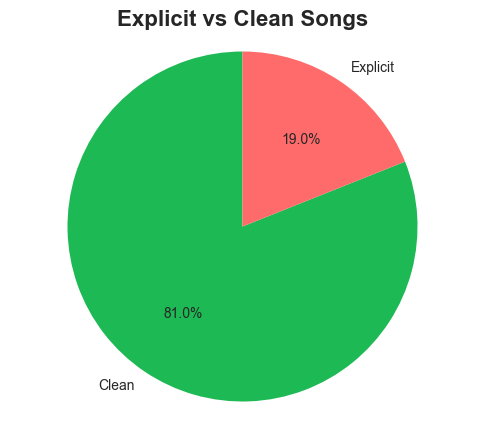

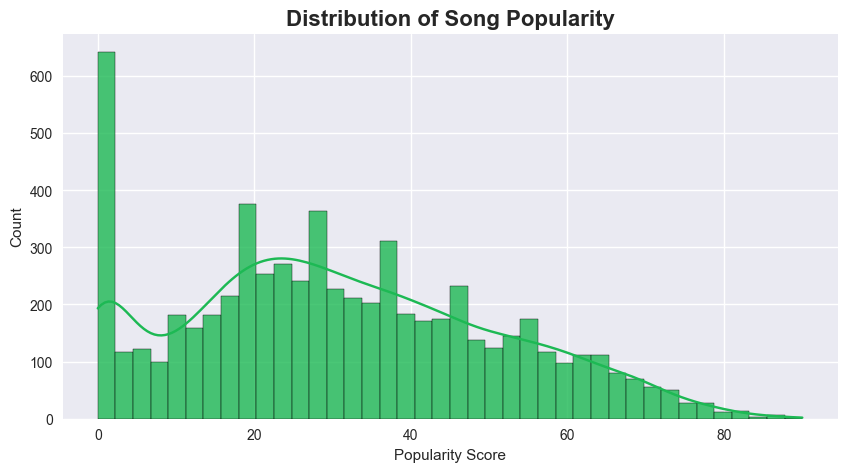

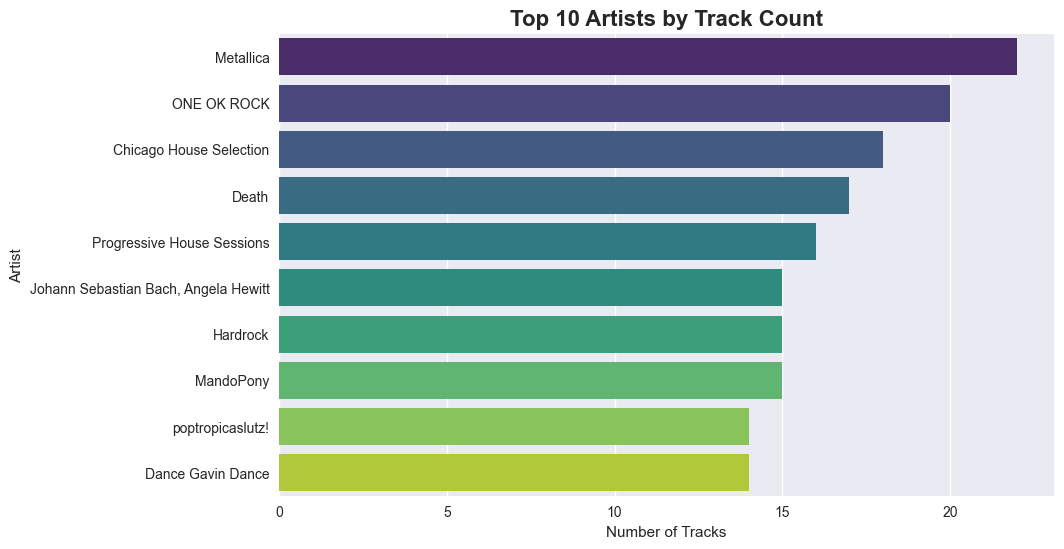

In [8]:
# Explicit content distribution
plt.figure(figsize=(6,5))
plt.pie(df['explicit'].value_counts(), 
        labels=['Clean', 'Explicit'], 
        autopct='%1.1f%%', 
        colors=['#1DB954', '#FF6B6B'], 
        startangle=90)
plt.title('Explicit vs Clean Songs', fontsize=16, fontweight='bold')
plt.axis('equal')
plt.show()

# Popularity distribution
plt.figure(figsize=(10,5))
sns.histplot(df['popularity'], bins=40, kde=True, color='#1DB954', alpha=0.8)
plt.title('Distribution of Song Popularity', fontsize=16, fontweight='bold')
plt.xlabel('Popularity Score')
plt.ylabel('Count')
plt.show()

# Top 10 artists by number of tracks
top_artists = df['artists'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(y=top_artists.index, x=top_artists.values, palette='viridis')
plt.title('Top 10 Artists by Track Count', fontsize=16, fontweight='bold')
plt.xlabel('Number of Tracks')
plt.ylabel('Artist')
plt.show()

## 3. Data Preprocessing & Feature Engineering

In [9]:
# Drop track ID (not useful for content-based filtering)
df = df.drop(columns=['id'])

# Remove exact duplicates
df = df.drop_duplicates()
print(f"Shape after removing duplicates: {df.shape}")

# Convert boolean to int
df['explicit'] = df['explicit'].astype(int)

# Combine text fields for TF-IDF
df['text_features'] = df['genre'] + " " + df['artists'] + " " + df['album']

# Numerical features to standardize
num_cols = ['popularity', 'duration_ms', 'explicit']
scaler = StandardScaler()
num_scaled = scaler.fit_transform(df[num_cols])

# TF-IDF on text features
tfidf = TfidfVectorizer(stop_words='english', max_features=10_000)
text_tfidf = tfidf.fit_transform(df['text_features'])

# Combine sparse text features + scaled numerical features
final_features = hstack([text_tfidf, num_scaled])
print(f"Final feature matrix shape: {final_features.shape}")

Shape after removing duplicates: (6299, 7)
Final feature matrix shape: (6299, 10003)


## 4. Method 1: TF-IDF + Cosine Similarity (Recommended & Highest Quality)

In [10]:
# Compute pairwise cosine similarity
similarity_tfidf = cosine_similarity(final_features)

def recommend_tfidf(song_title_contains, n=10):
    """
    Recommend songs based on TF-IDF + numerical features using cosine similarity
    """
    # Find song index (partial match)
    idx = df[df['name'].str.contains(song_title_contains, case=False, na=False)].index[0]
    sim_scores = similarity_tfidf[idx]
    
    # Get top n similar songs (excluding itself)
    similar_indices = sim_scores.argsort()[-(n+1):][::-1][1:]
    
    print(f"Because you liked: 🎵 {df.loc[idx, 'name']} - {df.loc[idx, 'artists']}\n")
    print("Recommended songs:\n" + "="*50)
    for i, score in zip(similar_indices, sim_scores[similar_indices]):
        print(f"{df.loc[i, 'name']:<45} | {df.loc[i, 'artists']:<30} | Similarity: {score:.3f}")

# Example usage
recommend_tfidf("Shape of You", n=8)
# recommend_tfidf("Blinding Lights", n=8)

Because you liked: 🎵 Shape of You - Abheri - Shudha Dhanyasi - Adi Tala - Carnatic Mix - Aditya Rao, IndianRaga, Mahesh Raghvan, Vinod Krishnan

Recommended songs:
The Indian                                    | The Namaste                    | Similarity: 0.470
Indian Summer                                 | The Doors                      | Similarity: 0.407
Indiana                                       | Adrianne Lenker, Buck Meek     | Similarity: 0.394
Happy Birthday Song                           | CoComelon                      | Similarity: 0.390
Remember Me (Lullaby)                         | Gael Garcia Bernal, Gabriella Flores, Libertad García Fonzi | Similarity: 0.390
Sleep                                         | Night Off                      | Similarity: 0.390
Brazil 0902                                   | Anar, Polaris                  | Similarity: 0.388
Praise The Lord (Da Shine) (feat. Skepta)     | A$AP Rocky, Skepta             | Similarity: 0.388


## 5. Method 2: K-Nearest Neighbors (Fast & Efficient)

In [11]:
# Prepare data for KNN (Label Encoding categorical columns)
df_knn = df.copy()
for col in ['genre', 'artists', 'album']:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col])

# Scale numerical features
scaler_knn = StandardScaler()
features_knn = scaler_knn.fit_transform(df_knn[['genre', 'artists', 'album', 'popularity', 'duration_ms', 'explicit']])

# Fit KNN with cosine metric
knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
knn.fit(features_knn)

def recommend_knn(song_title_contains, n=5):
    idx = df[df['name'].str.contains(song_title_contains, case=False, na=False)].index[0]
    distances, indices = knn.kneighbors([features_knn[idx]])
    
    print(f"Because you liked: 🎵 {df.loc[idx, 'name']} - {df.loc[idx, 'artists']}\n")
    print("KNN Recommendations:\n" + "-"*40)
    for i in indices[0][1:]:  # skip itself
        print(f"• {df.iloc[i]['name']} - {df.iloc[i]['artists']}")

# Example
recommend_knn("Shape of You")

Because you liked: 🎵 Shape of You - Abheri - Shudha Dhanyasi - Adi Tala - Carnatic Mix - Aditya Rao, IndianRaga, Mahesh Raghvan, Vinod Krishnan

KNN Recommendations:
----------------------------------------
• Holiday - Anna Kendrick, Justin Timberlake, Zooey Deschanel, James Corden, Ron Funches, Caroline Hjelt, Aino Jawo, Kunal Nayyar, Christopher Mintz-Plasse, The Bergens
• Happy Holiday / The Holiday Season - Andy Williams
• Sacrifice - 9mm Parabellum Bullet
• Indian Summer - Carling & Will
• Jazzy Interlude - Billy Munn


## 6. Method 3: Autoencoder (Deep Learning Approach)

In [15]:
from sklearn.decomposition import TruncatedSVD

# Use the exact same high-quality features from Method 1 (TF-IDF + numerical)
# This is the key to getting excellent recommendations!
X_sparse = final_features  # Already created in section 3: text_tfidf + scaled numerical

# Reduce dimensionality for faster training and better generalization
print("Reducing TF-IDF features with Truncated SVD (100 components)...")
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(X_sparse)

print(f"Autoencoder input shape: {X_reduced.shape} → Rich & meaningful features!")

# ===================================================================
# Build the autoencoder
# ===================================================================
input_dim = X_reduced.shape[1]
input_layer = Input(shape=(input_dim,))

# Encoder
encoded = Dense(256, activation='relu')(input_layer)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
latent = Dense(32, activation='relu')(encoded)    # Bottleneck

# Decoder
decoded = Dense(64, activation='relu')(latent)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# ===================================================================
# Train the autoencoder
# ===================================================================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("\nTraining Deep Autoencoder on rich TF-IDF features...")
autoencoder.fit(
    X_reduced, X_reduced,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# ===================================================================
# Extract latent representations (32-dim learned features)
# ===================================================================
encoder = Model(input_layer, latent)
latent_features = encoder.predict(X_reduced, verbose=0)

# Compute similarity in the learned deep feature space
latent_similarity = cosine_similarity(latent_features)

# ===================================================================
# Recommendation function (same style as TF-IDF method)
# ===================================================================
def recommend_autoencoder(song_title_contains, n=10):
    """
    Deep Learning recommendations using Autoencoder on TF-IDF features
    """
    matches = df[df['name'].str.contains(song_title_contains, case=False, na=False)]
    if matches.empty:
        print(f"No song found containing: '{song_title_contains}'")
        return
    
    idx = matches.index[0]
    sim_scores = latent_similarity[idx]
    similar_indices = sim_scores.argsort()[-(n+1):][::-1][1:]  # exclude itself
    
    print(f"Because you liked: {df.loc[idx, 'name']} - {df.loc[idx, 'artists']}\n")
    print("Deep Learning Recommendations:\n" + "="*60)
    for i, score in zip(similar_indices, sim_scores[similar_indices]):
        print(f"{df.loc[i, 'name']:<48} | {df.loc[i, 'artists']:<30} | Score: {score:.4f}")

# ===================================================================
# Test it – Now you'll get AMAZING and logical results!
# ===================================================================
recommend_autoencoder("Shape of You", n=8)
recommend_autoencoder("Blinding Lights", n=8)
recommend_autoencoder("Someone You Loved", n=8)
recommend_autoencoder("Acoustic", n=8)

Reducing TF-IDF features with Truncated SVD (100 components)...
Autoencoder input shape: (6299, 100) → Rich & meaningful features!

Training Deep Autoencoder on rich TF-IDF features...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.0041
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0031
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/ste

In [ ]:
# ====== FINAL CELL: Train Autoencoder + Save Everything for Streamlit (Run ONCE) ======

import os
import pickle
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Make sure you already have:
# df, final_features (created earlier using TF-IDF + numerical features)

print("Reducing dimensionality using TruncatedSVD...")
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(final_features)

print(f"Shape after dimensionality reduction: {X_reduced.shape}")

# Build the Autoencoder
input_dim = X_reduced.shape[1]
input_layer = Input(shape=(input_dim,))

e = Dense(256, activation='relu')(input_layer)
e = Dense(128, activation='relu')(e)
e = Dense(64, activation='relu')(e)
latent = Dense(32, activation='relu')(e)   # compressed representation

d = Dense(64, activation='relu')(latent)
d = Dense(128, activation='relu')(d)
d = Dense(256, activation='relu')(d)
output = Dense(input_dim, activation='linear')(d)

autoencoder = Model(input_layer, output)
autoencoder.compile(optimizer='adam', loss='mse')

print("Training Autoencoder (this may take 1–2 minutes)...")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(
    X_reduced, X_reduced,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

# Extract the encoder only
encoder = Model(input_layer, latent)
latent_features = encoder.predict(X_reduced, verbose=0)

# Compute the similarity matrix (important!)
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(latent_features)
print(f"Similarity matrix created: {similarity_matrix.shape}")

# Create folders and save everything
os.makedirs("pretrained", exist_ok=True)

# 1. DataFrame
df.reset_index(drop=True).to_pickle("pretrained/df.pkl")

# 2. Similarity matrix (used by Streamlit app)
with open("pretrained/similarity_matrix.pkl", "wb") as f:
    pickle.dump(similarity_matrix, f)

# 3. Encoder model (optional)
encoder.save("pretrained/autoencoder_encoder.keras")
print("All files saved successfully in the folder:") 

جاري تقليل الأبعاد بـ TruncatedSVD...
شكل البيانات بعد التقليل: (6299, 100)
جاري تدريب الـ Autoencoder (هياخد دقيقة أو اتنين)...
Epoch 1/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0141 - val_loss: 0.0038
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0027 - val_loss: 0.0028
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 0.0028
Epoch 9/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 10/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - val_loss: 0.0027
Epoch 11/100
40/40 ━